In [5]:
import numpy as np 
import pandas as pd 

import os

In [1]:
!pip install torch-lr-finder
import torch
from PIL import Image
import os
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import torchvision.models as models
import albumentations as A
import cv2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_lr_finder import *
from torch_lr_finder import LRFinder
import matplotlib.pyplot as plt
import torchvision.models as models
from sklearn.model_selection import train_test_split
from numpy import asarray 

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
        os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/resnet18/resnet18.pth' '/root/.cache/torch/hub/checkpoints/resnet18-333f7ec4.pth'

In [3]:
tfms = transforms.Compose([
    
    transforms.RandomRotation(degrees=(-10,10)),
    transforms.RandomAffine(degrees=(-16, 16), translate=(.1,.1)),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
                           
                          ])
v_tfms = transforms.Compose([
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

In [6]:
df = pd.read_csv('../input/character/Train.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209966 entries, 0 to 209965
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 1.2 GB


In [8]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df.iloc[0,1:]

pixel0      0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Name: 0, Length: 784, dtype: int64

In [10]:
X, y = df.iloc[:,1:].values, df['label'].values
X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size=0.2)

In [11]:
class NumDataset(Dataset):
    def __init__(self, DataFrame, Labels, Transform, test=False, valid=False):
        self.df = DataFrame
        self.transform = Transform
        self.lbs = Labels
        self.test = test
        self.valid = valid
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        
        x = self.df[index].reshape(28,28)
        x = np.expand_dims(x, axis=0)
        image = x.astype(np.float32)
        
        if self.valid:
            return v_tfms(torch.tensor(image)), self.lbs[index]
        elif self.test:
            return v_tfms(torch.tensor(image))
        else:
            image = self.transform(torch.tensor(image))
            return image, self.lbs[index]
    

In [12]:
num_trainset = NumDataset(X_train, Y_train, tfms)
num_trainloader = DataLoader(num_trainset, batch_size=64, shuffle=True, num_workers=4)

num_validset = NumDataset(X_valid, Y_valid, tfms, valid=True)
num_validloader = DataLoader(num_validset, batch_size=64, shuffle=True, num_workers=4)

/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


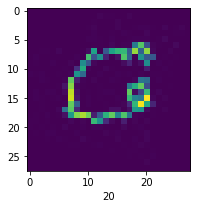

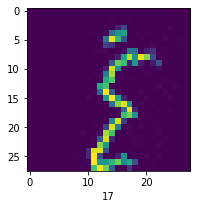

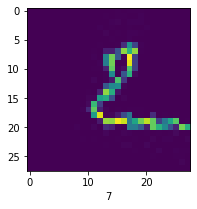

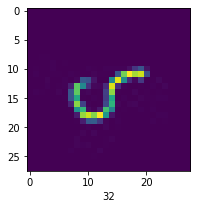

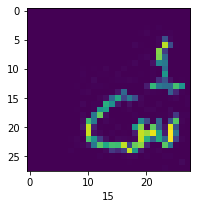

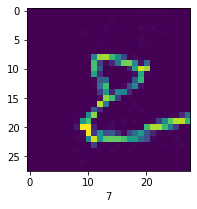

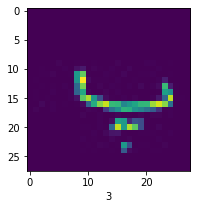

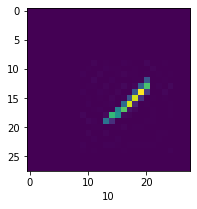

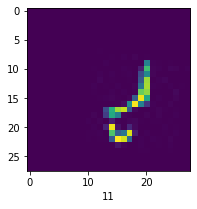

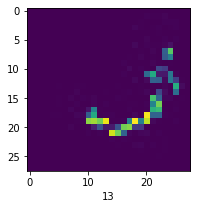

In [13]:
def visualize(image, label):
    plt.figure(figsize=(4, 3))
    plt.xlabel(label)
    plt.imshow(image)

for i in range(10):
    visualize(num_trainset[i][0][-1][:], num_trainset[i][1] )

* The transforms should help. Slight angle rotation and affine transformation should make the training data more robust
* Dataset seems to be working. Lets load some models

In [14]:
def train_(epocs, loader, model, valid_set, early_stop):
    best_v_acc = 0.0
    bad_rds = 0
    for epoch in range(epocs):  # loop over the dataset multiple times
        print("Training...")
        correct = 0
        total = 0
        running_loss = 0.0
        for i, data in enumerate(loader, 0):
            model.train()
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss=criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            max_index = outputs.max(dim = 1)[1]
            correct += (max_index == labels).sum().item()
            total += labels.size(0)

            
            # print statistics
            running_loss += loss.item()
            if i % len(loader) == len(loader) - 1:    
                print('[epoc: %d, %5d] training loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / len(loader)))
                running_loss = 0.0
        print("Training Accuracy = {}".format(100 * correct / total))
        
        
        correct = 0
        total = 0
        running_loss = 0.0
        print("Validating...")
        for i, data in enumerate(valid_set, 0):
            model.eval()
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to('cuda'), labels.to('cuda')
                outputs = model(inputs)
                loss=criterion(outputs, labels)
                max_index = outputs.max(dim = 1)[1]
                correct += (max_index == labels).sum().item()
                total += labels.size(0)
                
                # print statistics
                running_loss += loss.item()
                if i % len(valid_set) == len(valid_set) - 1:    
                    print('[epoc: %d, %5d] valid loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / len(loader)))
                    running_loss = 0.0
                    
        if (100 * correct / total) > best_v_acc:
            best_v_acc = 100 * correct / total
            print("BEST MODEL SAVED")
            torch.save(model.state_dict(), 'best_model.pt')
            bad_rds = 0
        else:
            bad_rds += 1
        print("\nvalid Accuracy = {}".format(100 * correct / total))
        
        if bad_rds == early_stop:
            print("EARLY STOPPING AFTER ", bad_rds, " BAD ROUNDS")
            return 

In [15]:
model_ft = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [16]:
model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 35, bias=True)
model_ft = model_ft.to("cuda")

In [17]:
criterion = nn.CrossEntropyLoss()

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.87E+00


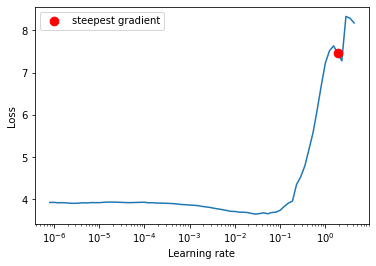

In [18]:

optimizer = optim.SGD(model_ft.parameters(), lr=1e-7, momentum=0.9)
lr_finder = LRFinder(model_ft, optimizer, criterion)
lr_finder.range_test(num_trainloader, end_lr=100, num_iter=100)
lr_finder.plot()
lr_finder.reset()

In [19]:
optimizer = optim.SGD(model_ft.parameters(), lr=1e-2, momentum=0.9)

In [20]:
train_(40, num_trainloader, model_ft, num_validloader, 3)

Training...
[epoc: 1,  2625] training loss: 0.762
Training Accuracy = 75.6673731336175
Validating...
[epoc: 1,   657] valid loss: 0.077
BEST MODEL SAVED

valid Accuracy = 89.54850692956137
Training...
[epoc: 2,  2625] training loss: 0.376
Training Accuracy = 87.74319529445384
Validating...
[epoc: 2,   657] valid loss: 0.043
BEST MODEL SAVED

valid Accuracy = 94.3706243749107
Training...
[epoc: 3,  2625] training loss: 0.303
Training Accuracy = 90.01976519896174
Validating...
[epoc: 3,   657] valid loss: 0.038
BEST MODEL SAVED

valid Accuracy = 95.01595466018955
Training...
[epoc: 4,  2625] training loss: 0.265
Training Accuracy = 91.32355392565428
Validating...
[epoc: 4,   657] valid loss: 0.053

valid Accuracy = 94.3706243749107
Training...
[epoc: 5,  2625] training loss: 0.240
Training Accuracy = 92.19750910866097
Validating...
[epoc: 5,   657] valid loss: 0.029
BEST MODEL SAVED

valid Accuracy = 96.29709006048483
Training...
[epoc: 6,  2625] training loss: 0.228
Training Accuracy = 

In [21]:
model_ft.load_state_dict(torch.load('best_model.pt'))
model_ft.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
test_df = pd.read_csv('../input/character/Test.csv')

In [25]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
X_test = test_df.iloc[:,:].values
len(X_test)

34966

In [27]:
test_set = NumDataset(X_test, None, v_tfms, test=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=4)

In [28]:
len(test_loader)

547

In [29]:
test_preds = []
with torch.no_grad():
    for x in test_loader:
        x = x.to('cuda')
        y_pred = model_ft(x)
        

        test_preds += y_pred.cpu().numpy().argmax(1).tolist()

    
test_preds = np.array(test_preds)

In [30]:
test_preds


array([ 0,  0,  0, ..., 34, 34, 34])

/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


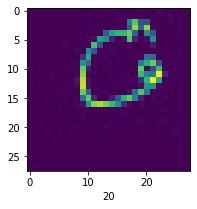

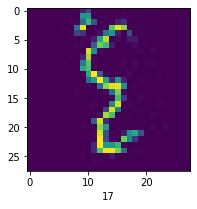

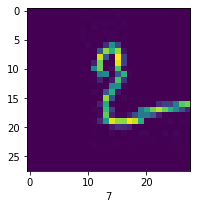

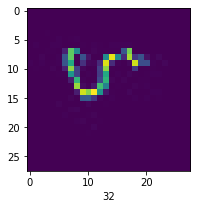

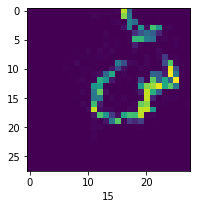

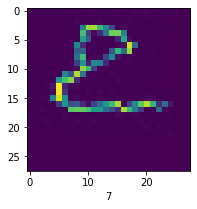

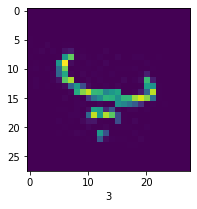

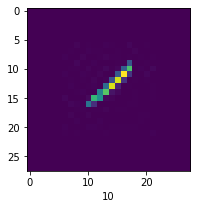

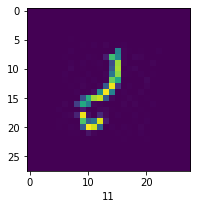

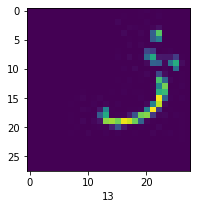

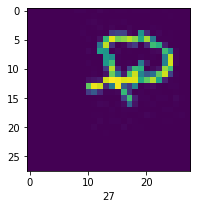

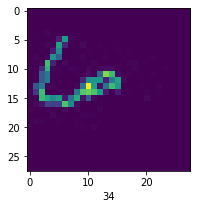

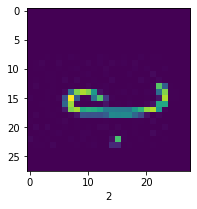

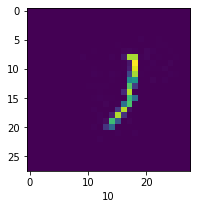

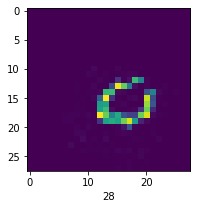

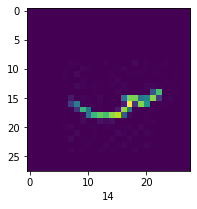

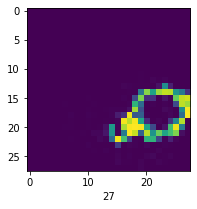

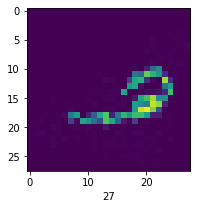

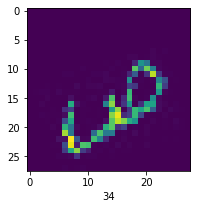

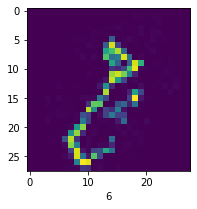

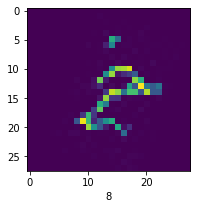

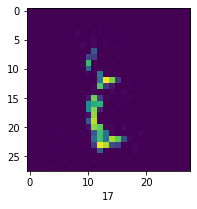

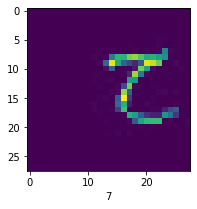

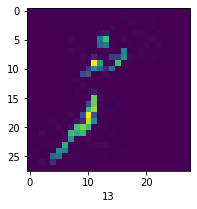

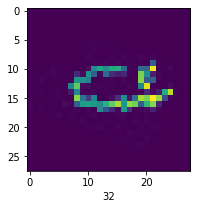

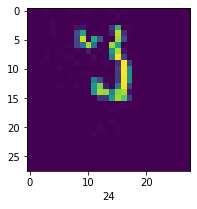

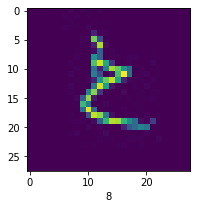

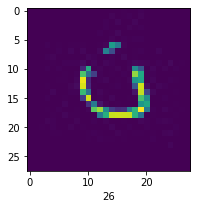

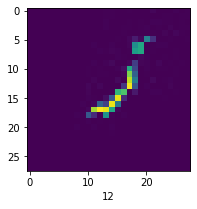

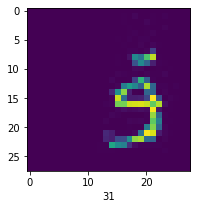

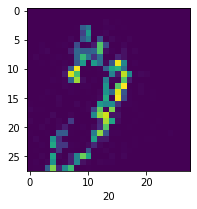

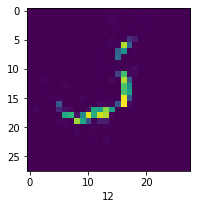

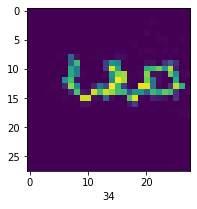

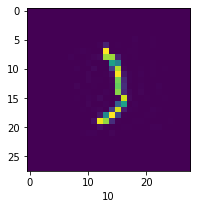

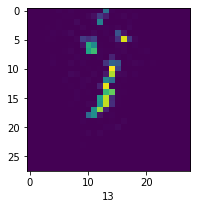

In [37]:
def visualize(image, label):
    plt.figure(figsize=(4, 3))
    plt.xlabel(label)
    plt.imshow(image)

for i in range(35):
    visualize(num_trainset[i][0][-1][:], num_trainset[i][1] )